# Quantitative Analysis of Price & Daily Returns


The process of designing and developing trading strategies based on mathematical and statistical studies is known as quantitative trading. It is a highly technical field of finance.

In [ ]:
!pip install mpl_finance
!pip install yfinance
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install mplfinance 

In [2]:
import numpy as np, pandas as pd
# dataloader
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
# date
import datetime as dt
import matplotlib.dates as mdates
# stats
from scipy import stats
from scipy.stats import norm, skew
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
# visualization
import mplfinance as mfp
from mpl_finance import candlestick_ohlc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
matplotlib.rc('figure', figsize=(16, 6))

In [3]:
def clear(df):
    print(f"Length of data before: {len(df)}")
    df.dropna(inplace=True)
    print(f"Length of data after: {len(df)}")

In [4]:
# VanEck Egypt Index ETF 
ticker = 'EGPT'
start = dt.datetime(2018, 1, 1)
end = dt.datetime.today()

df = pdr.get_data_yahoo(ticker, start, end)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-02,18.200001,18.309999,18.100000,18.150000,18.150000,12400
2023-03-03,18.139999,18.450001,18.139999,18.379999,18.379999,600
2023-03-06,18.480000,18.480000,18.100000,18.190001,18.190001,4800
2023-03-07,18.420000,18.420000,17.760000,17.760000,17.760000,10100
2023-03-08,17.719999,17.719999,17.520000,17.600000,17.600000,19042


## Exploratory Data Analysis

### Data columns represents:

**Open/Close** - Captures the opening/closing price of the stock

**Adj_Open/Adj_Close** - An adjusted opening/closing price is a stock's price on any given day of trading that has been revised to include any dividend distributions, stock splits, and other corporate actions that occurred at any time before the next day's open.

**Volume** - It records the number of shares which are being traded on any given day of trading.

**High/Low** - It tracks the highest and the lowest price of the stock during a particular day of trading.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2018-01-02 to 2023-03-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1304 non-null   float64
 1   High       1304 non-null   float64
 2   Low        1304 non-null   float64
 3   Close      1304 non-null   float64
 4   Adj Close  1304 non-null   float64
 5   Volume     1304 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 71.3 KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000
mean,26.790659,27.012584,26.533060,26.769716,25.169240,16173.345092
std,5.388543,5.412262,5.360170,5.398406,4.422172,41077.250385
min,16.450001,16.700001,16.170000,16.299999,16.092361,0.000000
25%,23.600000,23.907500,23.352500,23.607501,22.231164,2100.000000
50%,26.129999,26.285001,25.910000,26.110001,25.048207,5600.000000
75%,30.872500,31.000000,30.540001,30.804999,28.321802,14700.000000
max,40.250000,40.970001,40.029999,40.419998,36.570274,619100.000000


**Pandas' resample()** method is used to facilitate control and flexibility on the frequency conversion of the time series data. We can specify the time intervals to resample the data to monthly, quarterly, or yearly, and perform the required operation over it.

In [7]:
monthly_mean = df.resample('M').mean()
monthly_mean.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-31,33.723333,33.937618,33.510953,33.800476,30.581214,19595.238095
2018-02-28,33.314737,33.744737,32.782632,33.385263,30.205547,34900.000000
2018-03-31,36.898095,37.217143,36.422381,36.927618,33.410517,53057.142857
2018-04-30,39.683810,39.988572,39.230952,39.584286,35.814155,60004.761905
2018-05-31,37.873636,38.110909,37.376818,37.772273,34.174723,42309.090909


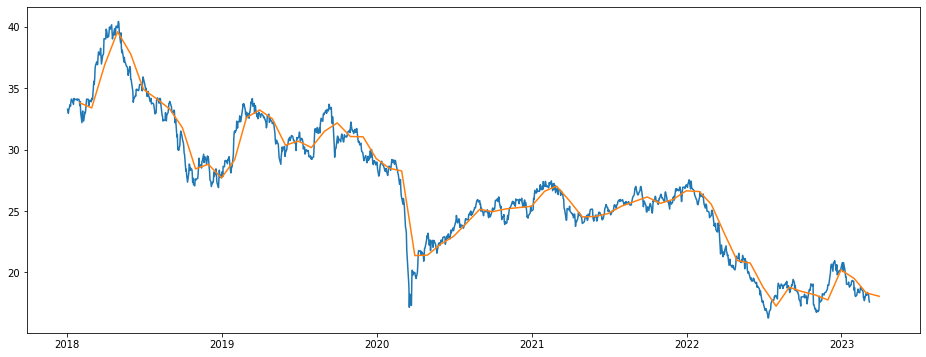

In [8]:
plt.plot(df.Close, label='')
plt.plot(monthly_mean.Close, label='monthly mean')

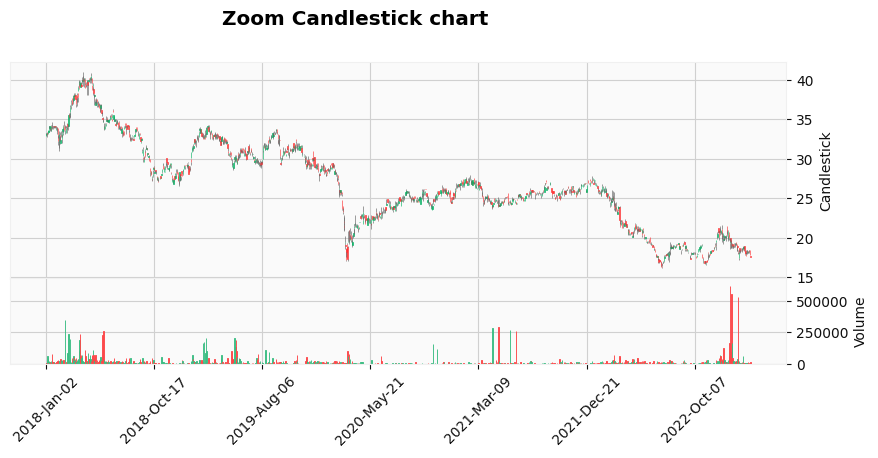

In [9]:
kwargs = dict(type='candle', title ='Zoom Candlestick chart',ylabel='Candlestick',figratio=(20,8),figscale=0.75, volume=True)
mfp.plot(df,**kwargs,style='yahoo')

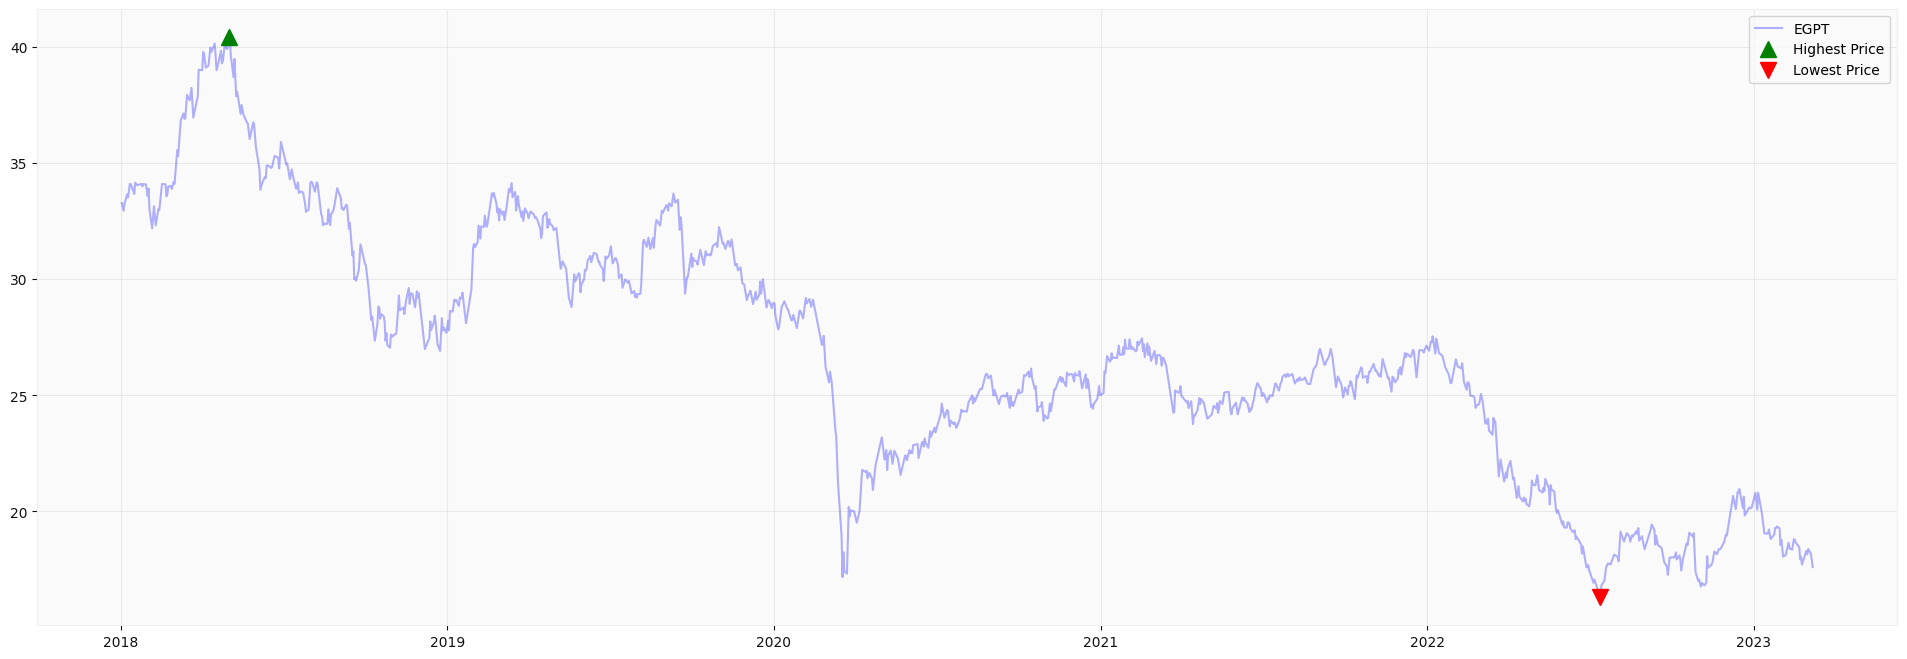

In [10]:
max_value, min_value = max(df['Close']), min(df['Close'])

plt.figure(figsize=(24, 8))
plt.grid(True, alpha = .4)

plt.plot(df['Close'], color = 'b', label = ticker, alpha=0.3)
plt.plot(df.loc[df.Close == max_value].index, max_value, '^', color = 'g', markersize = 12, label='Highest Price')
plt.plot(df.loc[df.Close == min_value].index, min_value, 'v', color = 'r', markersize = 12, label='Lowest Price')
plt.legend();

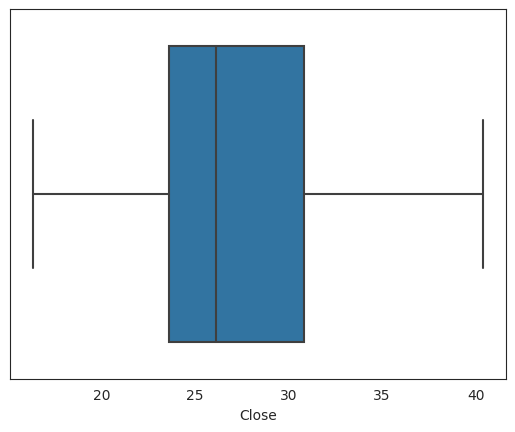

In [11]:
# EWA data shows few outliers and a left skewed graph
sns.set_style(style='white')
ax = sns.boxplot(x=df["Close"])

#### Percentage change between the current and a prior element.

By default, it computes the % change from the previous row.
This is handy for comparing the percentage change of values over time.

The formula used in pct_change() is:

    Return = {(Price at t) - (Price at t-1)} / {Price at t-1}

In [12]:
# assign `Adj Close` to `daily_close`
daily_close = df[['Close']]

# returns as fractional change
daily_return = daily_close.pct_change()

# replacing NA values with 0
daily_return.fillna(0, inplace=True)

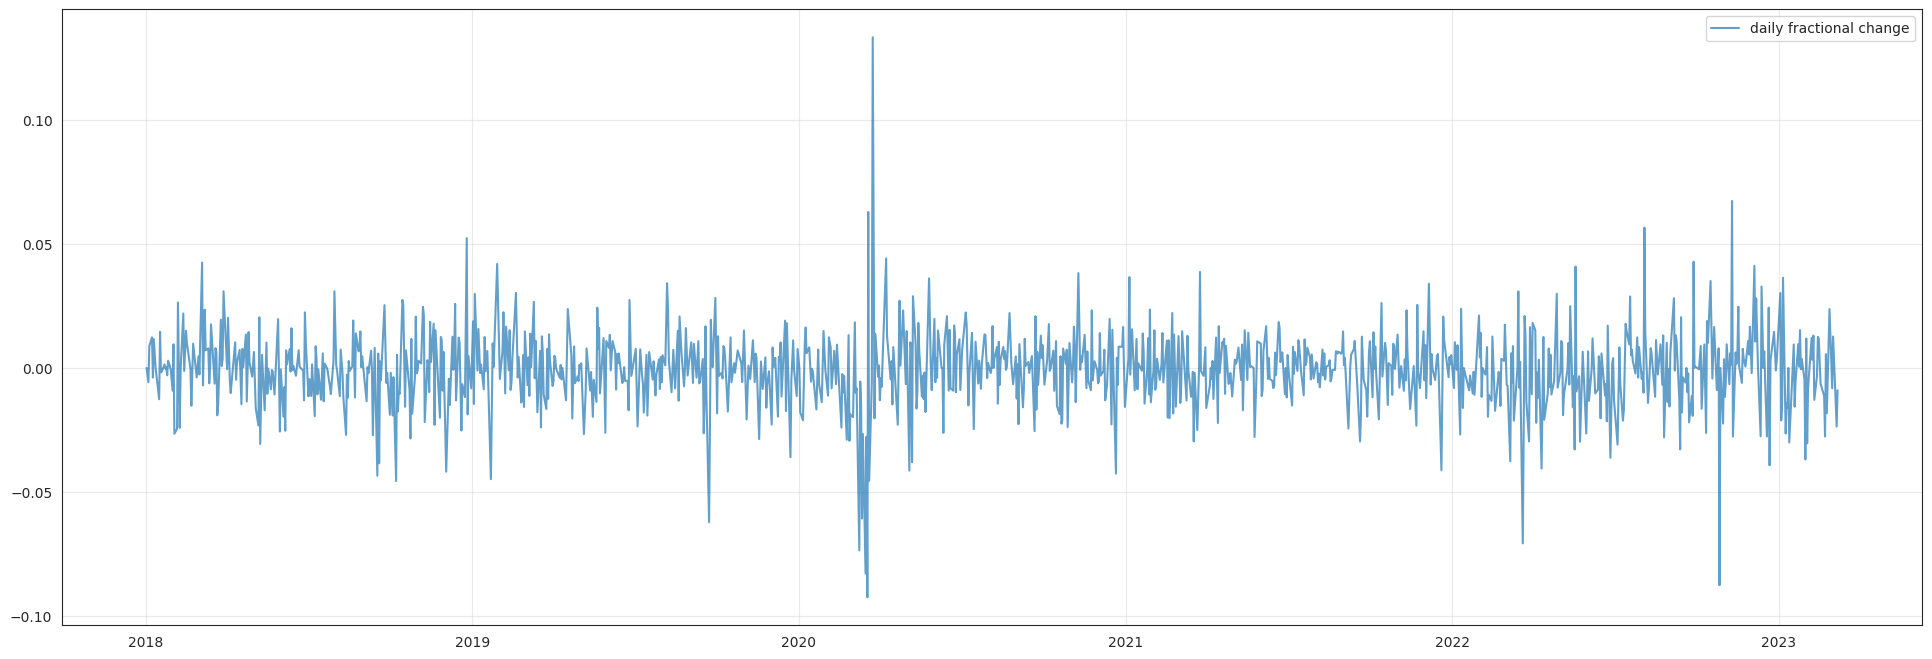

In [13]:
plt.figure(figsize=(24, 8))
plt.grid(True, alpha = .4)

plt.plot(daily_return.Close, label='daily fractional change', alpha=0.7)

plt.legend(loc='upper right');

## Instantaneous rate of return 

In [14]:
df['return'] = round(np.log(df.Close).diff() * 100, 2)
df['return'].dropna(inplace = True)
df['return'].head()

Date
2018-01-02     NaN
2018-01-03   -0.42
2018-01-04   -0.57
2018-01-05    0.88
2018-01-08    1.23
Name: return, dtype: float64

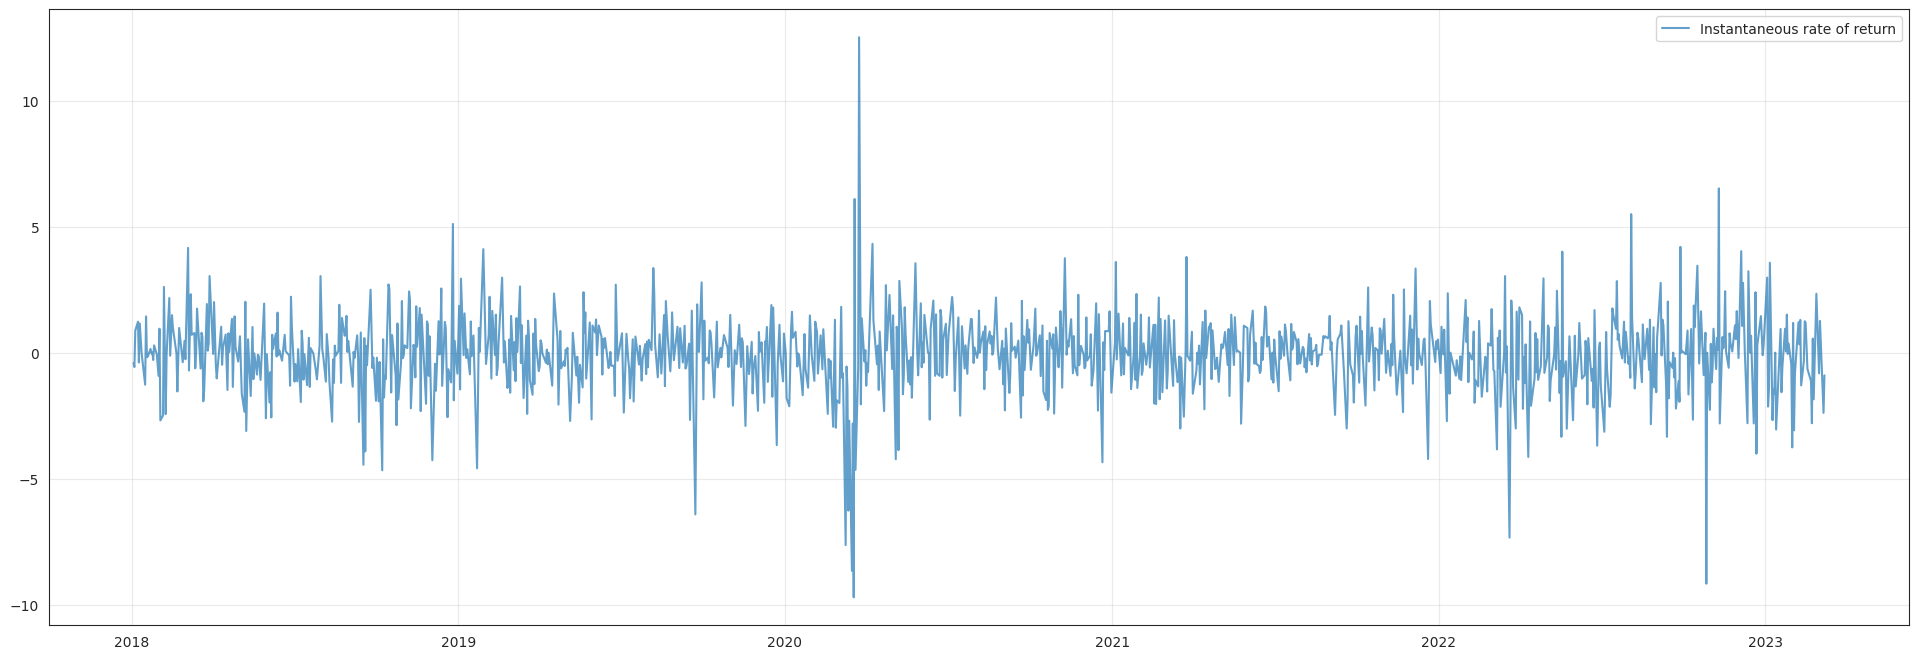

In [15]:
plt.figure(figsize=(24, 8))
plt.grid(True, alpha = .4)

plt.plot(df['return'], label='Instantaneous rate of return', alpha=0.7)

plt.legend(loc='upper right');

## Monthly returns

By resampling the data to months (for business days), we may obtain the month's last trading day.

In [16]:
monthly_return = df.resample('M').apply(lambda x: x[-1]).pct_change()
monthly_return

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,-0.004704,0.000882,0.002111,0.013401,0.013401,-0.575916,-1.445652
2018-03-31,0.138553,0.150411,0.159795,0.146635,0.146635,3.604938,6.414634
2018-04-30,0.039440,0.030644,0.035547,0.022809,0.022809,0.058981,-1.115132
2018-05-31,-0.097104,-0.103816,-0.105738,-0.104986,-0.104986,-0.463291,6.428571
...,...,...,...,...,...,...,...
2022-11-30,0.113085,0.108581,0.118523,0.117059,0.117059,-0.675676,-1.726872
2022-12-31,0.069149,0.063191,0.065495,0.063191,0.076909,2.000000,-0.818182
2023-01-31,-0.047264,-0.051511,-0.082459,-0.081228,-0.081228,5.666667,-13.533333


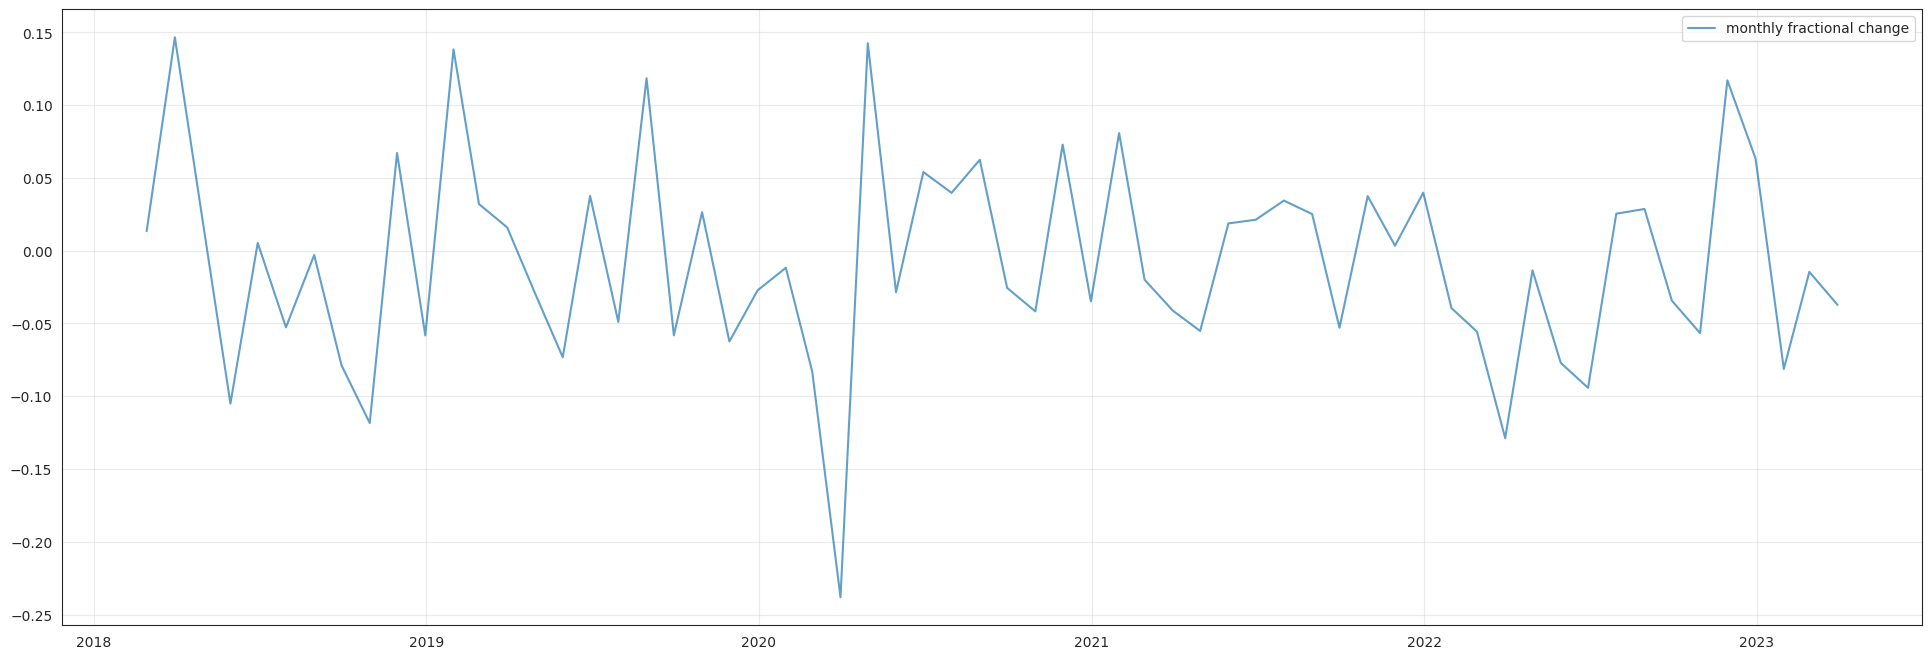

In [17]:
plt.figure(figsize=(24, 8))
plt.grid(True, alpha = .4)

plt.plot(monthly_return.Close, label='monthly fractional change', alpha=0.7)

plt.legend(loc='upper right');

## Moving Averages (21 days)

Moving averages smooth down any oscillations or spikes in the data, resulting in a smoother curve for the company's performance.

In [18]:
period = 21
df['21-day'] = df['Close'].rolling(period).mean()
df['std'] = df['Close'].rolling(period).std()

# calculate bollinger bands using std dev
df['upper_bollinger'] = df['21-day'] + (2 * df['std'])
df['lower_bollinger'] = df['21-day'] - (2 * df['std'])

clear(df)

Length of data before: 1304
Length of data after: 1284


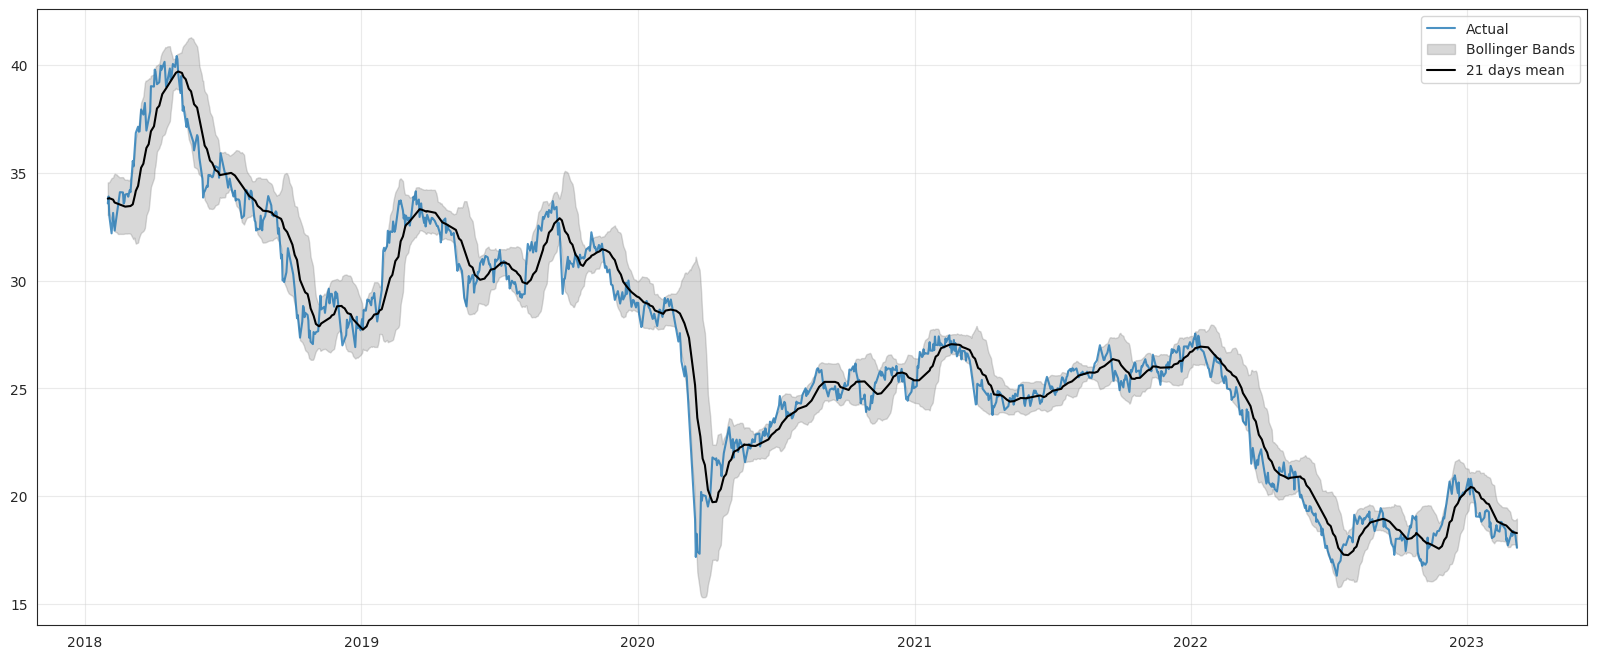

In [19]:
plt.figure(figsize=(20, 8))
plt.grid(True, alpha = .4)

plt.plot(df['Close'], label='Actual', alpha=0.8)
plt.fill_between(df.index,df['lower_bollinger'], df['upper_bollinger'], color='gray', alpha=0.3, label = 'Bollinger Bands')
plt.plot(df['21-day'], color='black', label='21 days mean')
plt.legend();